# Random Forest To Predict Stock Return

In [346]:
import yfinance as yf 
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

In [347]:
end_date = dt.datetime.now().date()
start_date = end_date - dt.timedelta(3650)
prediction_duration = 30
# start_date = None
# end_date=None
stock_name='TCS.NS'
stock = yf.Ticker(stock_name).history( start=start_date, end=end_date, auto_adjust=False)

In [348]:
training_data = pd.DataFrame()
training_data['close'] = stock[['Adj Close']]

In [349]:
sm = training_data.ta.sma(append= True)

In [350]:
rs =training_data.ta.rsi(append= True)

In [351]:
df = training_data

In [352]:
df["Ret"] = df["close"].pct_change()
df.reset_index(inplace=True)
name = "Ret"

In [353]:
ret_fieldi=f"Ret{prediction_duration}_i"
ret_field=f"Ret{prediction_duration}"
df[ ret_fieldi] = df[name].rolling(prediction_duration).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df[ret_field] = df[ret_fieldi].shift(-prediction_duration)
df["Output"] = df[ret_field].apply(lambda x :1 if  x > 0 else -1 )
df["Output"] = df["Output"].astype(int)
del df[ret_field]
df = df.dropna()
#df.tail(10)

### Input Preparation 

In [354]:
X= df.iloc[:,2:4]
y = df.iloc[:,-1]
classes = [1,-1]

In [355]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

### Model 

In [356]:
classifier = RandomForestClassifier()

In [357]:
classifier.fit(X, y)

RandomForestClassifier()

In [358]:
classifier.score(X,y)

1.0

In [359]:
y_pred = classifier.predict(X)

In [360]:
confusion_matrix(y, y_pred)

array([[ 944,    0],
       [   0, 1490]])

In [361]:
classifier = RandomForestClassifier()

In [362]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [363]:
y_pred = classifier.predict(X_test)

In [364]:
confusion_matrix(y_test, y_pred)

array([[110,  88],
       [ 36, 253]])

In [365]:
classifier = RandomForestClassifier()

In [366]:
classifier.fit(X_train,y_train)

RandomForestClassifier()

### Predictive Performance

/Users/shritiwari/opt/anaconda3/envs/new_env/bin/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


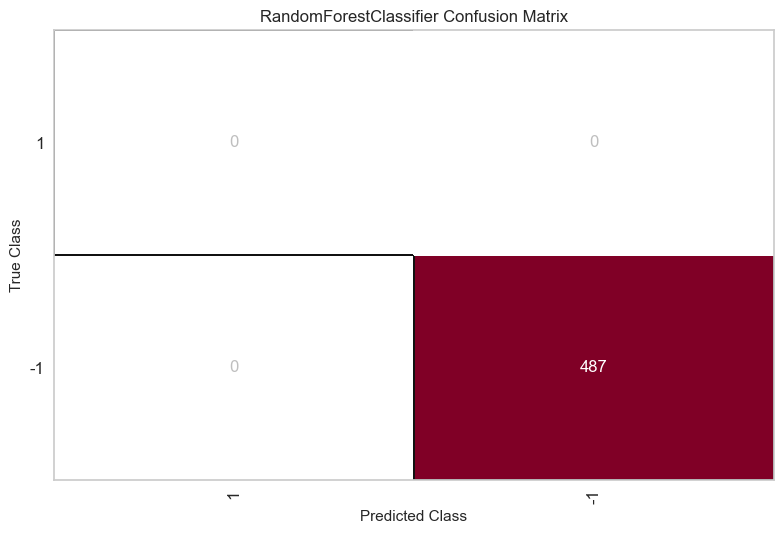

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [367]:
cm =ConfusionMatrix(classifier, classes =  classes )
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()


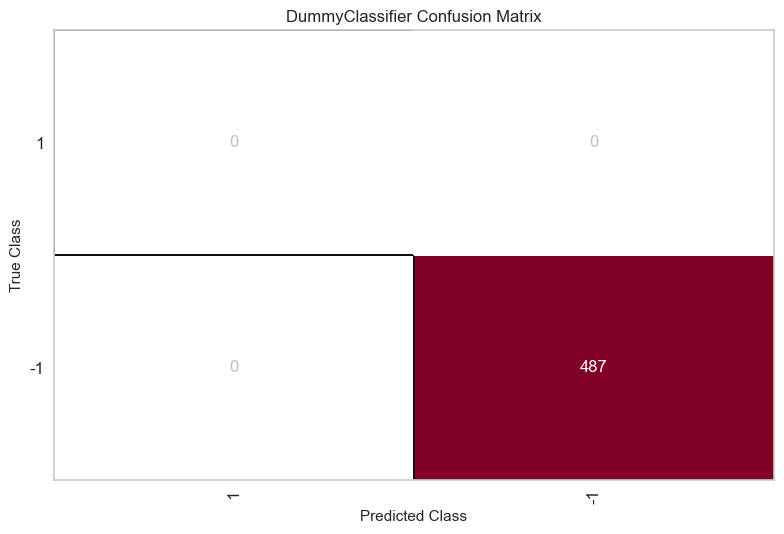

<Axes: title={'center': 'DummyClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [368]:
dummy_model = DummyClassifier(strategy="most_frequent")
cm =ConfusionMatrix(dummy_model, classes = classes)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()



/Users/shritiwari/opt/anaconda3/envs/new_env/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shritiwari/opt/anaconda3/envs/new_env/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


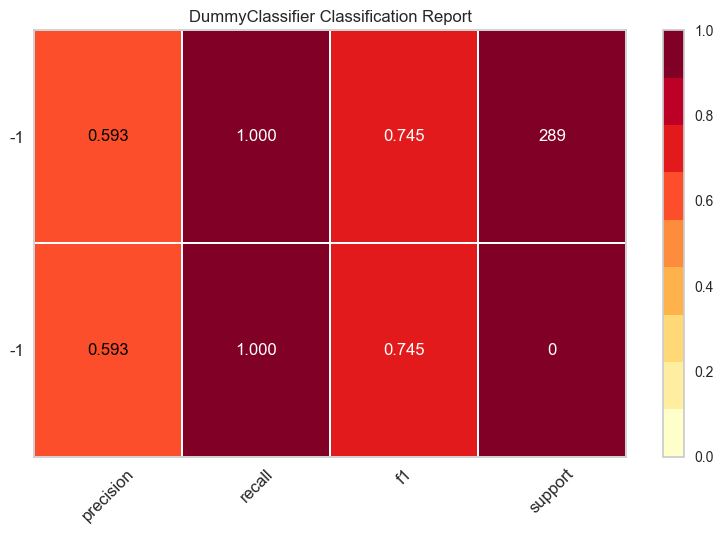

<Axes: title={'center': 'DummyClassifier Classification Report'}>

In [369]:
visualizer = ClassificationReport(dummy_model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

/Users/shritiwari/opt/anaconda3/envs/new_env/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shritiwari/opt/anaconda3/envs/new_env/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


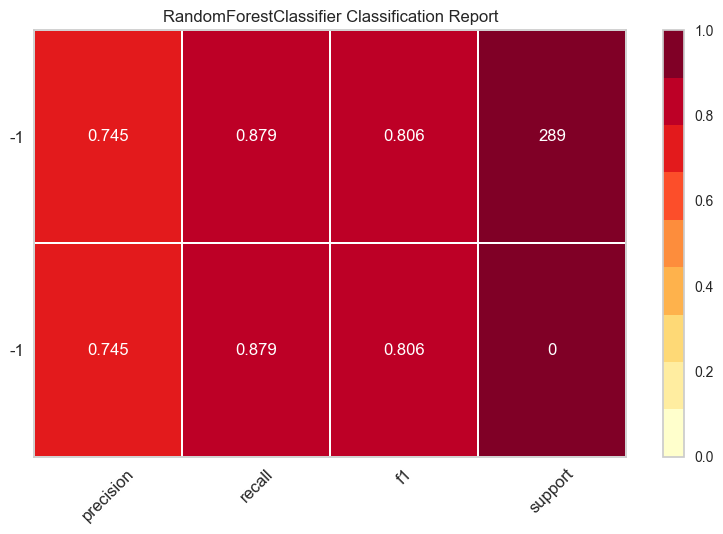

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [370]:
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

In [371]:
df['Pred'] = model.predict(df[['SMA_10','RSI_14']])
df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_23948/2423637309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred'] = model.predict(df[['SMA_10','RSI_14']])
/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_23948/2423637309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_23948/2423637309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Strat Return Long Only = 1259.413958915882 %
Strat Return = 3404.033300286211 %
Buy and Hold Return = 335.173418374216 %


/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_23948/2423637309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)


In [372]:
df = df.dropna()

In [373]:
ret=df.CumRet_L
ret.mean()/ret.std()

1.017851327692078

In [374]:
ret=df.bhRet
ret.mean()/ret.std()

1.17514094641467

In [375]:
ret=df.CumRet
ret.mean()/ret.std()

0.8786560820738157

In [376]:
df['Pred'] = dummy_model.predict(df[['SMA_10','RSI_14']])
df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_23948/3864236609.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Positions_L"][df["Positions_L"] == -1] = 0


Strat Return Long Only = 337.59663419207664 %
Strat Return = 337.59663419207664 %
Buy and Hold Return = 334.1049934852479 %


In [377]:
ret=df.CumRet_L
ret.mean()/ret.std()

1.180472427712108

In [378]:
ret=df.CumRet
ret.mean()/ret.std()

1.180472427712108

In [379]:
ret=df.bhRet
ret.mean()/ret.std()

1.1730293360385318